In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from keras.applications.densenet import preprocess_input
from keras.preprocessing import image
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, AveragePooling2D, Concatenate, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import plot_roc_curve, classification_report, plot_confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.layers import BatchNormalization
from keras.applications.mobilenet_v2 import MobileNetV2
import seaborn as sn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def save_dump(file_path, data, labels):
    file = open(file_path, 'wb')
    # dump information to that file
    pickle.dump((data, labels), file)
    # close the file
    file.close()
    pass


def load_data(path_file):
    file = open(path_file, 'rb')
    # dump information to that file
    (pixels, labels) = pickle.load(file)
    # close the file
    file.close()
    print(pixels.shape)
    print(labels.shape)
    return pixels, labels


def view_chart(performance, people, chart):
    fig, ax = plt.subplots()
    y_pos = np.arange(len(people))
    ax.barh(y_pos, performance, align='center', color=['green', 'yellowgreen', 'dodgerblue','orange'])
    for index, value in enumerate(performance):
        plt.text(value, index, str(value))
    ax.set_yticks(y_pos)
    ax.set_yticklabels(people)
    ax.invert_yaxis()
    ax.set_xlabel('Number')
    ax.set_title(chart)
    plt.xlim(0, max(performance) + 400)
    plt.show()
    pass


def view_model_history(model_history):
    # view
    accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    pass


def get_labels_smids(labels_name):
    labels_number = []
    for lb in labels_name:
        if lb == 'Abnormal_Sperm':
            labels_number.append(0)
        elif lb == 'Non-Sperm':
            labels_number.append(1)
        else:
            labels_number.append(2)
    return np.array(labels_number)


def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cmx, annot=True, fmt='g')
    print(cmx_data)
    plt.show()

In [ ]:
# Dataset SMIDS
CATEGORIES = ["Abnormal_Sperm", "Non-Sperm", "Normal_Sperm"]
smids_train = '/content/drive/MyDrive/human_sperm_morphology_dataset/SMIDS/dataset/smids_train.data'
smids_valid = '/content/drive/MyDrive/human_sperm_morphology_dataset/SMIDS/dataset/smids_valid.data'
smids_datatest = '/content/drive/MyDrive/human_sperm_morphology_dataset/SMIDS/dataset/smids_datatest.data'
# smids_datatrain = '/content/drive/MyDrive/human_sperm_morphology_dataset/SMIDS/dataset/smids_datatrain.data'

data_smids_train, labels_smids_train = load_data(smids_train)
data_smids_valid, labels_smids_valid = load_data(smids_valid)
data_smids_datatest, labels_smids_datatest = load_data(smids_datatest)
# data_smids_datatrain, labels_smids_datatrain = load_data(smids_datatrain)

# format data
data_smids_train = data_smids_train.astype("float32") / 255.0
data_smids_valid = data_smids_valid.astype("float32") / 255.0
data_smids_datatest = data_smids_datatest.astype("float32") / 255.0

lb = LabelBinarizer()
labels_smids_train_one_hot = lb.fit_transform(labels_smids_train)
labels_smids_valid_one_hot = lb.fit_transform(labels_smids_valid)
labels_smids_datatest_one_hot = lb.fit_transform(labels_smids_datatest)
# labels_smids_datatrain_one_hot = lb.fit_transform(labels_smids_datatrain)

labels_smids_train_one_hot.shape, labels_smids_valid_one_hot.shape, labels_smids_datatest_one_hot.shape

(3846, 40, 40, 3)
(3846,)
(962, 40, 40, 3)
(962,)
(1202, 40, 40, 3)
(1202,)


((3846, 3), (962, 3), (1202, 3))

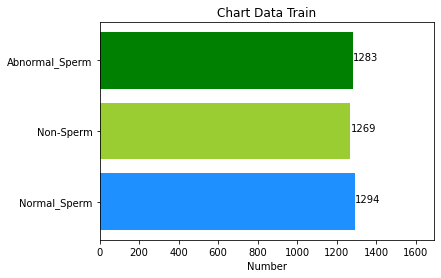

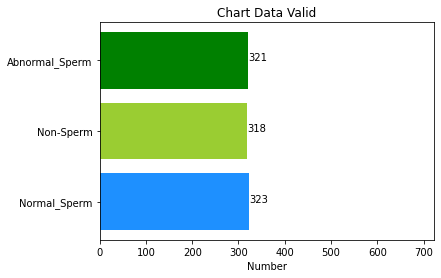

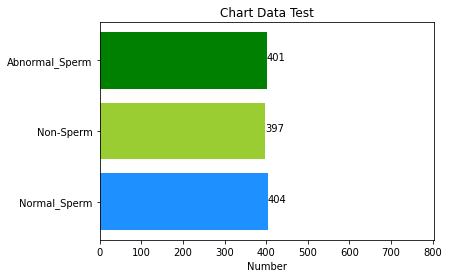

In [ ]:
# view data
labels_smids_train_number = get_labels_smids(labels_smids_train)
labels_smids_valid_number = get_labels_smids(labels_smids_valid)
labels_smids_test_number = get_labels_smids(labels_smids_datatest)

view_chart([sum(labels_smids_train_number == 0), sum(labels_smids_train_number == 1), sum(labels_smids_train_number == 2)], 
           ["Abnormal_Sperm", "Non-Sperm", "Normal_Sperm"], 'Chart Data Train')

view_chart([sum(labels_smids_valid_number == 0), sum(labels_smids_valid_number == 1), sum(labels_smids_valid_number == 2)], 
           ["Abnormal_Sperm", "Non-Sperm", "Normal_Sperm"], 'Chart Data Valid')

view_chart([sum(labels_smids_test_number == 0), sum(labels_smids_test_number == 1), sum(labels_smids_test_number == 2)], 
           ["Abnormal_Sperm", "Non-Sperm", "Normal_Sperm"], 'Chart Data Test')

In [ ]:
def created_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(40, 40, 3))
    for layer in base_model.layers:
        layer.trainable = False

    # Create new model.
    headModel = base_model.output
    headModel = BatchNormalization()(headModel)
    headModel = GlobalAveragePooling2D()(headModel)
    headModel = Dropout(0.4)(headModel)
    headModel = Dense(1024, activation='relu')(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(3, activation='softmax')(headModel)

    model = Model(inputs=base_model.input, outputs=headModel)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")],
    )
    return model

model = created_model()
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 20, 20, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 20, 20, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 20, 20, 32)   0           ['bn_Conv1[0][0]']               
                               

Epoch 1/200
61/61 [==============================] - 19s 38ms/step - loss: 0.8271 - accuracy: 0.6329 - val_loss: 1.0990 - val_accuracy: 0.3711
Epoch 2/200
61/61 [==============================] - 1s 13ms/step - loss: 0.6687 - accuracy: 0.7306 - val_loss: 1.0259 - val_accuracy: 0.5489
Epoch 3/200
61/61 [==============================] - 1s 13ms/step - loss: 0.6234 - accuracy: 0.7569 - val_loss: 0.9303 - val_accuracy: 0.6102
Epoch 4/200
61/61 [==============================] - 1s 13ms/step - loss: 0.6005 - accuracy: 0.7553 - val_loss: 0.6849 - val_accuracy: 0.7173
Epoch 5/200
61/61 [==============================] - 1s 13ms/step - loss: 0.5909 - accuracy: 0.7637 - val_loss: 0.5779 - val_accuracy: 0.7557
Epoch 6/200
61/61 [==============================] - 1s 12ms/step - loss: 0.5818 - accuracy: 0.7733 - val_loss: 0.5216 - val_accuracy: 0.7973
Epoch 7/200
61/61 [==============================] - 1s 13ms/step - loss: 0.5652 - accuracy: 0.7761 - val_loss: 0.4948 - val_accuracy: 0.8098
Epoch

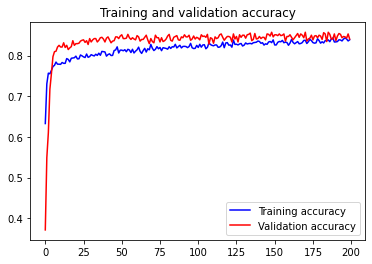

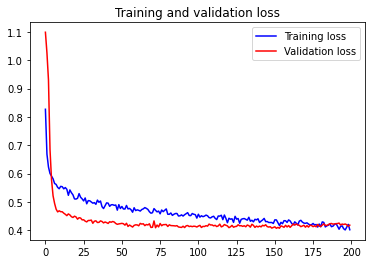

In [ ]:
size = 64
ep = 200
ver = 1

model_history = model.fit(data_smids_train, labels_smids_train_one_hot, batch_size=size, epochs=ep, verbose=ver, 
                          validation_data=(data_smids_valid, labels_smids_valid_one_hot), shuffle=True)

view_model_history(model_history)

In [ ]:
test_eval = model.evaluate(data_smids_datatest, labels_smids_datatest_one_hot, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

38/38 [==============================] - 1s 13ms/step - loss: 0.5597 - accuracy: 0.8070
Test loss: 0.559675395488739
Test accuracy: 0.8069883584976196


Accuracy: 80.70 %
              precision    recall  f1-score   support

     Class 0       0.80      0.77      0.79       401
     Class 1       0.89      0.82      0.85       397
     Class 2       0.74      0.83      0.78       404

    accuracy                           0.81      1202
   macro avg       0.81      0.81      0.81      1202
weighted avg       0.81      0.81      0.81      1202

[[309  20  72]
 [ 26 326  45]
 [ 49  20 335]]


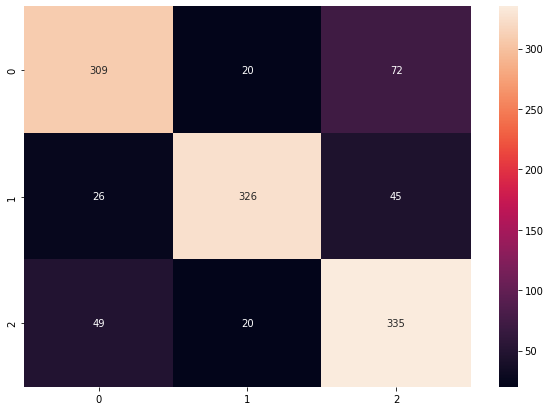

In [ ]:
y_predict = model.predict(data_smids_datatest)
y_target = np.argmax(y_predict, axis=1)


print("Accuracy: %.2f %%" % (100 * accuracy_score(labels_smids_test_number, y_target)))
target_names = ["Class {}".format(i) for i in range(len(np.unique(labels_smids_test_number)))]
print(classification_report(labels_smids_test_number, y_target, target_names=target_names))
print_cmx(labels_smids_test_number, y_target)

In [ ]:
model.save("/content/drive/MyDrive/human_sperm_morphology_dataset/models/smids_mobiv2.h5")

In [ ]:
mymodel = created_model()
mymodel.load_weights("/content/drive/MyDrive/human_sperm_morphology_dataset/models/smids_mobiv2.h5")

test_eval = mymodel.evaluate(data_smids_datatest, labels_smids_datatest_one_hot, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

38/38 [==============================] - 2s 14ms/step - loss: 0.5425 - accuracy: 0.8103
Test loss: 0.5425392985343933
Test accuracy: 0.8103161454200745


Accuracy: 81.03 %
              precision    recall  f1-score   support

     Class 0       0.82      0.76      0.79       401
     Class 1       0.92      0.81      0.86       397
     Class 2       0.73      0.86      0.79       404

    accuracy                           0.81      1202
   macro avg       0.82      0.81      0.81      1202
weighted avg       0.82      0.81      0.81      1202

[[305  15  81]
 [ 25 323  49]
 [ 43  15 346]]


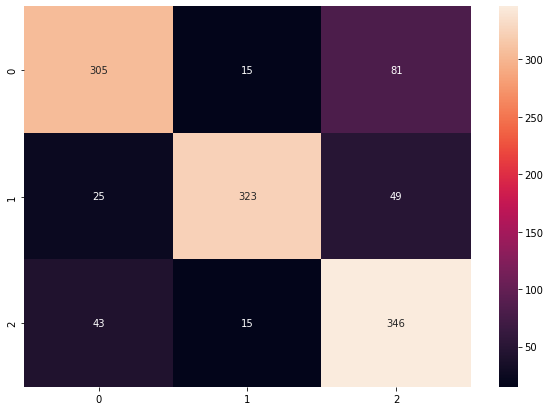

In [ ]:
y_predict = mymodel.predict(data_smids_datatest)
y_target = np.argmax(y_predict, axis=1)


print("Accuracy: %.2f %%" % (100 * accuracy_score(labels_smids_test_number, y_target)))
target_names = ["Class {}".format(i) for i in range(len(np.unique(labels_smids_test_number)))]
print(classification_report(labels_smids_test_number, y_target, target_names=target_names))
print_cmx(labels_smids_test_number, y_target)